ST6704 MidTerm - Luis Moros
=====

The data come from an online lending company.  There are 90,000 normal customers (TARGET = “Normal”) and 4,000 default customers (TARGET = “Default”). 
The goal of this assignment is “Estimate the loan defaulting risk for a given customer”.  The instructor will give a presentation to explain this assignment in class as well.
You need to complete this exam by complete the following five tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dropColumns(df,clmns):
    return df.drop(clmns, axis=1)

def transformDateToEpoch(df,clmn):
        df[clmn] = pd.to_datetime(
                        df[clmn].apply(
                                        lambda x: str(int(x)) if not pd.isnull(x) else x\
                                      ))\
                            .astype('int64')//1e9
        return df
    
def transformTimeDeltaToEpoch(df,clmn):
        df[clmn] = pd.to_datetime(
                            pd.to_timedelta(df['last_job_opendate'], unit='D') + pd.datetime(1960, 1, 1))\
                            .astype('int64')//1e9
        return df
    
def transformMonthYearToEpoch(df,clmn):
        df[clmn] = pd.to_datetime(
                        df[clmn].apply(
                                       lambda x: str(int(x)*100 + 1) if not pd.isnull(x) else x 
                                      ))\
                            .astype('int64')//1e9
        return df    

def prepareDate(df):
        return df\
                .pipe(transformDateToEpoch, clmn='al_date1')\
                .pipe(transformDateToEpoch, clmn='al_date2')\
                .pipe(transformDateToEpoch, clmn='al_date3')\
                .pipe(transformDateToEpoch, clmn='al_date1_bank')\
                .pipe(transformDateToEpoch, clmn='al_date1_nbank')\
                .pipe(transformTimeDeltaToEpoch, clmn='last_job_opendate')\
                .pipe(transformMonthYearToEpoch, clmn='qmonth')\

def saveCsv(df,name):
        df.to_csv(path_or_buf=name, index=False)
        return df

def setEvent(df):
    df['event'] = df['TARGET'].apply(lambda x: 1 if x.lower()=='default' else 0)
    return df.drop('TARGET', axis=1)

In [3]:
df = \
    pd.read_csv('train.csv')\
       .pipe(dropColumns, clmns=['Unnamed: 0','uid'])\
       .pipe(prepareDate)\

In [8]:
def getmissPcntDf(d):
    obs, _ = d.shape
    return pd.DataFrame(d.apply(lambda x: (sum(x.isnull().values)/obs)*100), columns=['pcnt'])

def memoize(f):
    memo = {}
    def helper(d):
        if d.shape[0] not in memo:            
            memo[d.shape[0]] = f(d)
        return memo[d.shape[0]]
    return helper

getmissPcntDf = memoize(getmissPcntDf)

TASK #1: (50 Points)
====
There are large amount of missing values and there are significant amount of information in them.   Please utilize missing value information through (1) missing value indicator; (2) missing value pattern; and (3) smoothing missing value patterns.  After complete this task, report the following:
1.	All missing value indicators created and their relationship with the target variables.
2.	All missing value pattern variables created.

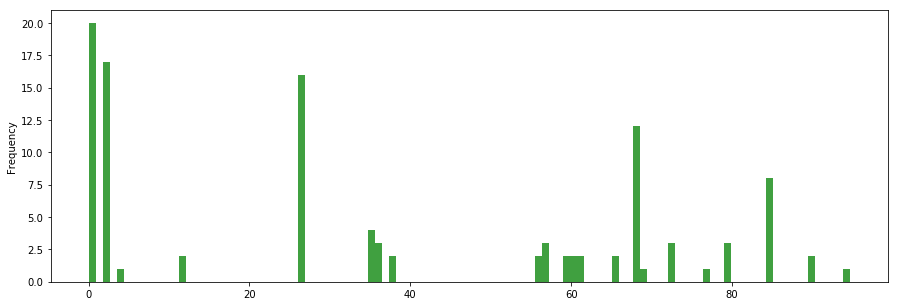

In [9]:
getmissPcntDf(df)['pcnt'].plot.hist(getmissPcntDf(df).shape[0], facecolor='green', alpha=0.75, figsize=(15,5));

In [10]:
from bitarray import bitarray
import struct

def namesOfColsWithMissingPcnt(df, lowerBound, upperBound):
    pcntDF = getmissPcntDf(df)
    return  pcntDF[(pcntDF['pcnt'] > lowerBound) & (pcntDF['pcnt'] < upperBound)].index
        
def getMissingPatern(x):
    b = bitarray(x, endian='little')
    b.invert()
    return b.to01()

def smooth(x, p, sf,target):
    s = x.groupby([target]).size()
    n1 = s['Default'] if 'Default' in s.index else 0
    n0 = s['Normal'] if 'Normal' in s.index else 0

    return np.log(
                    (n1+(p*sf))/
                   (n0+((1.0-p)*sf))
                 )

def smoothField(d, p, field, target):    
    temp = pd.DataFrame(
                    d.groupby([field]).apply(
                                    lambda x: smooth(x,p,100,target)), 
                                columns=['smoothed_{0}'.format(field)])\
                .merge(d, left_index=True, right_on=field)
        
    d['smoothed_{0}'.format(field)] =  temp['smoothed_{0}'.format(field)]   
    d.drop(field, axis=1, inplace=True)    

def smoothCategorical(d, target, exclude):
    t =d.groupby([target]).size()
    p = t['Default']/t['Normal'] 

    d.select_dtypes(include=['object'])\
        .columns\
        .difference(exclude)\
        .map(
                lambda field: smoothField(d, p, field, target)
        )
    return d

def impCols(d):
    return namesOfColsWithMissingPcnt(d, 0.0, 5.0)

def meanImpCols(d): 
    return df.loc[:,impCols(d)].select_dtypes(include=['float64','int64']).columns

def indicatorImpCols(d):
    return df.loc[:,impCols(d)].select_dtypes(include=['object']).columns

def mvp1Cols(d):
    return namesOfColsWithMissingPcnt(d, 5.0, 40.0)

def mvp2Cols(d):
    return namesOfColsWithMissingPcnt(d, 40.0, 80.0)

def mvp3Cols(d):
    return namesOfColsWithMissingPcnt(d, 80.0, 100.0)

def preparedCols(d):
    return impCols(d).union(mvp1Cols(d).union(mvp2Cols(d).union(mvp3Cols(d))))
from sklearn.model_selection import train_test_split

def prepareMissings(df):
    return pd.DataFrame(df.loc[:, meanImpCols(df)].apply(lambda x: x.fillna(x.mean()),axis=0))\
                .join(
                    pd.DataFrame(df.loc[:, indicatorImpCols(df)].apply(lambda x: x.fillna('unknown'),axis=0))
                ).join(
                    pd.DataFrame(df.loc[:,mvp1Cols(df)].apply(getMissingPatern,axis=1), columns=['mvp1'])
                ).join(
                    pd.DataFrame(df.loc[:,mvp2Cols(df)].apply(getMissingPatern,axis=1), columns=['mvp2'])
                ).join(
                    pd.DataFrame(df.loc[:,mvp3Cols(df)].apply(getMissingPatern,axis=1), columns=['mvp3'])
                ).join(
                    df[df.columns.difference(preparedCols(df))].select_dtypes(include=['object'])
                ).pipe(
                    smoothCategorical, target='TARGET', exclude=['TARGET']
                )
    
prepared_df = prepareMissings(df)
prepared_df                           

,cons_tot_m3_num,cons_tot_m3_pay,cons_tot_m3_p_catenum,cons_tot_m3_v_catenum,cons_tot_m3_visits,cons_tot_m12_num,cons_tot_m12_pay,cons_tot_m12_p_catenum,cons_tot_m12_v_catenum,cons_tot_m12_visits,...,smoothed_GENDER,smoothed_H_PROV,smoothed_P_PROV,smoothed_cons_cont,smoothed_cons_max_m12_paycate,smoothed_cons_max_m3_paycate,smoothed_cons_time_recent,smoothed_mvp1,smoothed_mvp2,smoothed_mvp3
0,5.000000,400.000000,3.000000,3.000000,25.000000,30.000000,2000.000000,4.000000,4.000000,150.000000,...,-3.642938,-3.241646,-3.331966,-4.064122,-3.935740,-3.986614,-3.874462,-4.869794,-3.622459,-3.452890
1,1.000000,30.000000,1.000000,1.000000,5.000000,1.000000,30.000000,1.000000,1.000000,5.000000,...,-2.749296,-3.241646,-2.966071,-3.489628,-3.951439,-3.879756,-3.874462,-5.016989,-4.200580,-3.452890
2,4.000000,300.000000,2.000000,3.000000,20.000000,5.000000,400.000000,2.000000,3.000000,25.000000,...,-3.642938,-3.319437,-3.358820,-3.685712,-3.462672,-3.395113,-3.874462,-4.422522,-3.622459,-3.452890
3,33.000000,4000.000000,7.000000,17.000000,1069.000000,52.000000,6000.000000,8.000000,18.000000,1520.000000,...,-3.642938,-4.023502,-3.094626,-4.064122,-4.049387,-4.204225,-3.874462,-3.098966,-3.581249,-3.452890
4,6.000000,900.000000,2.000000,2.000000,30.000000,17.000000,2000.000000,3.000000,4.000000,85.000000,...,-3.642938,-2.912635,-3.096033,-4.064122,-3.442957,-3.464659,-3.874462,-3.731312,-3.651313,-3.452890
5,1.000000,20.000000,1.000000,1.000000,5.000000,1.000000,20.000000,1.000000,1.000000,5.000000,...,-2.749296,-3.383035,-3.432168,-3.489628,-3.951439,-3.879756,-3.874462,-3.210690,-3.622459,-3.452890
6,28.000000,3000.000000,5.000000,14.000000,689.000000,48.000000,5000.000000,7.000000,17.000000,1238.000000,...,-3.642938,-2.904016,-3.029688,-4.064122,-4.046799,-3.467310,-3.874462,-5.637065,-4.800087,-3.452890
7,9.000000,700.000000,4.000000,4.000000,45.000000,9.000000,700.000000,4.000000,4.000000,45.000000,...,-2.749296,-3.092596,-3.096033,-3.489628,-3.935740,-3.986614,-3.874462,-4.811227,-1.509074,-3.452890
8,1.000000,30.000000,1.000000,1.000000,5.000000,1.000000,30.000000,1.000000,1.000000,5.000000,...,-3.642938,-2.904016,-3.029688,-3.489628,-3.951439,-3.879756,-3.874462,-5.016989,-2.450700,-3.452890
9,3.000000,600.000000,1.000000,2.000000,15.000000,5.000000,700.000000,1.000000,2.000000,25.000000,...,-3.642938,-4.023502,-4.327803,-3.685712,-3.462672,-3.395113,-3.874462,-5.202357,-3.622459,-3.452890


TASK #3: (30 Points)
===
Since there are significant number of categorical variables with high cardinality, to utilize a high cardinality categorical variable we can either perform smoothing or perform clustering.  Explain how you deal with this problem.

In [ ]:
prepared_df = smoothCategorical(prepared_df, target='TARGET', exclude=['TARGET'])
prepared_df

TAKS #2: (20 Points)
===
Suppose we define an outlier as any value which is bigger than mean plus 5 standard deviation, for each numerical variable report the percentage of outliers.  Also, explain how do you use deal with these outliers.


In [ ]:
plt.hist(prepared_df.skew(axis=0, skipna=True, numeric_only=True),bins=prepared_df.shape[1], facecolor='green', alpha=0.75);

In [ ]:
prepared_df.skew(axis=0, skipna=True, numeric_only=True).sort_values()

In [ ]:
def reduceSkewness(x):
    y = x
    skw = x.skew(axis=0, skipna=True)
    if skw < -0.5:
        y = x**2
        skw = y.skew(axis=0, skipna=True)
    if skw < -0.5:
        y = x**3
        skw = y.skew(axis=0, skipna=True) 
    if skw > 0.5:   
        y = (x + np.abs(np.min(x)))**0.5
        skw = y.skew(axis=0, skipna=True) 
    if skw > 0.5:   
        y = np.log(x + np.abs(np.min(x)) + 0.0000000000000000001)
        skw = y.skew(axis=0, skipna=True)  
    if skw > 0.5:   
        y = np.sqrt(x + np.abs(np.min(x)) + 0.0000000000000000001)
        skw = y.skew(axis=0, skipna=True) 
    if skw > 0.5:   
        y = 1/(x + np.abs(np.min(x)) + 0.0000000000000000001)
        skw = y.skew(axis=0, skipna=True)         
    if abs(skw) > 0.5:   
        y = x.rank()
        skw = y.skew(axis=0, skipna=True)  
    return y    

def eliminateOutliers(d,stds):
    return d[d.apply(lambda x: np.abs(x - x.mean()) / x.std() <= stds).all(axis=1)]    

traning_df = prepared_df\
        .select_dtypes(['float64','int64'])\
        .apply(reduceSkewness)\
        .pipe(eliminateOutliers, stds=5)\
        .join(prepared_df.loc[:,['TARGET']])\
        .pipe(setEvent)

In [ ]:
plt.hist(traning_df.skew(axis=0, skipna=True, numeric_only=True),bins=traning_df.shape[1], facecolor='green', alpha=0.75);

In [ ]:
traning_df.skew(axis=0, skipna=True, numeric_only=True).sort_values()

TASK #4: (100 Points)  
======
After data preparation, build one or multiple models on the TARGET variable “TARGET”.

In [ ]:
from sklearn.model_selection import train_test_split

def getTrainPlusValidationSets(d):
    """
    Sample train and test sets
    """
    x = d.loc[:,d.columns.difference(['event'])] 
    y = d.loc[:,['event']]
    x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.3, random_state=1)
    return  x_train, x_validation, y_train.iloc[:,0].ravel(), y_validation.iloc[:,0].ravel() 

x_train, x_validation, y_train, y_validation = getTrainPlusValidationSets(traning_df)

In [ ]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)
logreg.score(x_train, y_train)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition  import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(22)
logistic_pca_model = make_pipeline(StandardScaler(),
                           PCA(n_components=10), 
                           linear_model.LogisticRegression())
param_grid = {'pca__n_components' : [10,15,20,24]}
best_logistic_pca = GridSearchCV(logistic_pca_model, param_grid, n_jobs=-1, cv=5)
best_logistic_pca.fit(x_train, y_train)
best_logistic_pca_score = cross_val_score(best_logistic_pca, x_train, y_train, cv=5).mean()
best_logistic_pca_score

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


gradientBoosting = GradientBoostingClassifier(\
                                 n_estimators=100, 
                                 learning_rate=1.0,
                                 max_depth=1, 
                                 random_state=1)\
                    .fit(x_train, y_train)
    
gradientBoosting.score(x_train, y_train)  

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition  import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(22)

param_grid = {
                'n_estimators': [50, 100, 150],
             }

best_gradientBostting_pca = GridSearchCV(
                                GradientBoostingClassifier(\
                                    n_estimators=100, 
                                    learning_rate=1.0,
                                    max_depth=1, 
                                    random_state=1), 
                                param_grid, 
                                cv=5,
                                n_jobs=-1)\
                            .fit(x_train, y_train)
best_gradientBostting_pca_score = cross_val_score(best_gradientBostting_pca, x_train, y_train, cv=5).mean()
best_gradientBostting_pca_score

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, max_iter=1000, solver= 'adam', hidden_layer_sizes=(24,12,6), learning_rate_init= 0.1)
mlp.fit(x_train, y_train)
mlp.score(x_train, y_train)

TASK #5: (50 Points)
====
Perform scoring on the scoring data set. (Scoring data set has 6,800 cases)

In [ ]:
from sklearn import metrics

logistic_score = logreg.score(x_validation, y_validation)

logit_prediction = best_logistic_pca.predict(x_validation)
logistic_pca_score = metrics.accuracy_score(y_validation, logit_prediction)

gradientBoosting_prediction = gradientBoosting.predict(x_validation)
gb_score = metrics.accuracy_score(y_validation, gradientBoosting_prediction)

gradientBostting_prediction = best_gradientBostting_pca.predict(x_validation)
best_gb_score = metrics.accuracy_score(y_validation, gradientBostting_prediction)

mlp_prediction = mlp.predict(x_validation)
mlp_score = metrics.accuracy_score(y_validation, mlp_prediction)

pd.DataFrame([[logistic_score, logistic_pca_score, gb_score, best_gb_score, mlp_score]], 
             columns = ['logistic_score', 'logistic_pca_score', 'gb_score', 'best_gb_score', 'mlp_score'] )